## SI epidemic simulations: node removal

In [1]:
import networkx as nx
import EoN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec

from tqdm import tqdm

In [2]:
TAU = 0.1
TMAX = 50.0
N_TRIALS = 5
NRUNS = 5

In [3]:
# Import Reddit Hyperlink network
edges = np.loadtxt('data/edges.csv', delimiter=',', dtype=int, skiprows=1)
G = nx.Graph()
G.add_edges_from(edges)

# Import communities
node_community = pd.read_csv('data/communities.csv', index_col=0)

# Extract 5 largest communities
print(node_community.value_counts().head())

top_community_ids = node_community.value_counts().head().index.get_level_values(0).to_list()
top_community_nodes = {community_rank: node_community[node_community == community_id].dropna().index.to_list()
                       for community_rank, community_id in enumerate(top_community_ids)}

modularity_class
11                  5757
8                   5358
7                   4408
16                  2951
10                  2334
dtype: int64


In [4]:
def simulate_si(G: nx.Graph, tau: float, tmax: float, top_community_nodes: dict[int, list[int]], nruns: int) -> np.ndarray:
    """Docstring"""

    t_grid = np.linspace(0, tmax, 100)
    infected = np.zeros((nruns, len(top_community_nodes), len(t_grid)))

    for run in range(nruns):
        initial_infected = np.random.choice(top_community_nodes[0])
        
        sim = EoN.fast_SIR(G, tau, gamma=0, initial_infecteds=initial_infected, tmax=tmax, return_full_data=True)
        
        for community, nodes in top_community_nodes.items():
            I = [sum([1 for status in sim.get_statuses(nodes, t).values() if status == 'I']) for t in t_grid]
            infected[run, community] = I
        
    mean_infected = np.mean(infected, axis=0)

    return mean_infected

## Random

In [5]:
# Percent of nodes to remove
remove_percents = [0.05, 0.1, 0.15, 0.2, 0.25]

# Dictionary to store final results
remove_percent_infected = {}

for remove_percent in remove_percents:
    
    # Array to store results of each trial
    mean_trial_infected = np.zeros((N_TRIALS, len(top_community_nodes), len(np.linspace(0, TMAX, 100))))
    
    print(f"Random: {remove_percent * 100}%")

    for trial in tqdm(range(N_TRIALS)):

        # Randomly remove nodes from the network
        G_reduced = G.copy()
        G_reduced.remove_nodes_from(np.random.choice(G.nodes(), int(remove_percent * len(G.nodes()))))

        # Filter out removed nodes from top communities
        top_community_nodes_reduced = {community: [node for node in nodes if node in G_reduced.nodes()]
                                       for community, nodes in top_community_nodes.items()}

        # Run simulations
        mean_run_infected = simulate_si(G_reduced, tau=TAU, tmax=TMAX, nruns=NRUNS,
                                        top_community_nodes=top_community_nodes_reduced)

        # Store results
        mean_trial_infected[trial] = mean_run_infected
    
    # Average over trials
    mean_trial_infected = np.mean(mean_trial_infected, axis=0)

    # Store results
    remove_percent_infected[remove_percent] = mean_trial_infected

Random: 5.0%


100%|██████████| 5/5 [01:13<00:00, 14.70s/it]


Random: 10.0%


100%|██████████| 5/5 [01:08<00:00, 13.78s/it]


Random: 15.0%


100%|██████████| 5/5 [01:06<00:00, 13.22s/it]


Random: 20.0%


100%|██████████| 5/5 [00:58<00:00, 11.79s/it]


Random: 25.0%


100%|██████████| 5/5 [00:53<00:00, 10.63s/it]


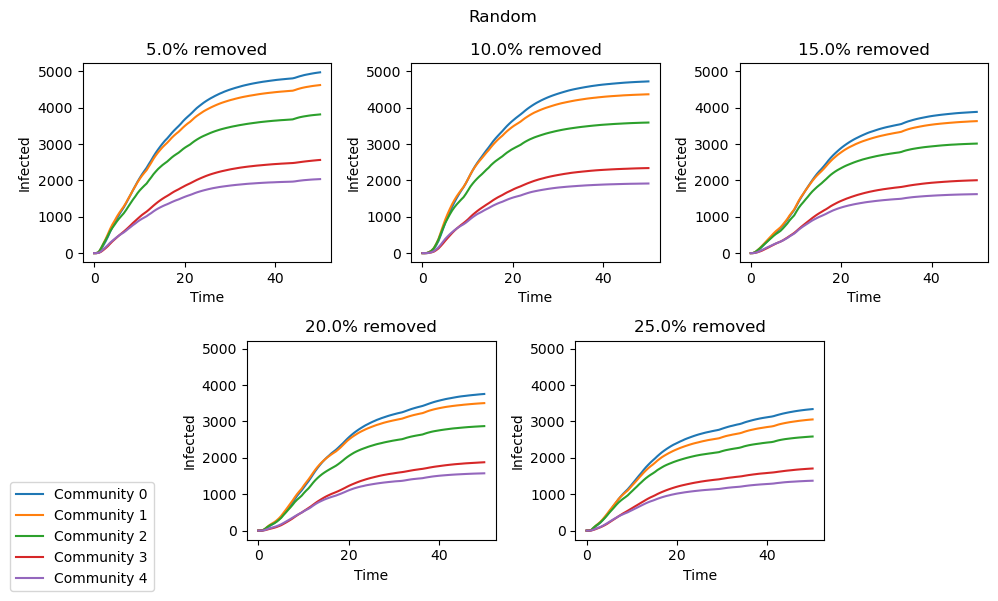

In [6]:
# Plot the results
fig = plt.figure(figsize=(10, 6))
fig.suptitle('Random')
gs = fig.add_gridspec(2, 6)

ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:4], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 4:], sharey=ax1)
ax4 = fig.add_subplot(gs[1, 1:3], sharey=ax1)
ax5 = fig.add_subplot(gs[1, 3:5], sharey=ax1)

axs = [ax1, ax2, ax3, ax4, ax5]

for ax, remove_percent in zip(axs, remove_percents):
    for community in top_community_nodes:
        ax.plot(np.linspace(0, TMAX, 100), remove_percent_infected[remove_percent][community], label=f"Community {community}")
    ax.set_title(f"{remove_percent * 100}% removed")
    ax.set_xlabel('Time')
    ax.set_ylabel('Infected')

# Common legend
legend = fig.legend(*ax.get_legend_handles_labels(), loc='lower left', bbox_to_anchor=(0, 0))

plt.tight_layout()
plt.show()

## Eigenvector

In [17]:
# Import eigenvector centralities
node_eigenvector = pd.read_csv('data/eigenvector_centrality.csv', index_col=0)

# Sort nodes by eigenvector centrality
top_node_eigenvector = node_eigenvector.sort_values(by='eigenvector', ascending=False)

In [18]:
# Percent of nodes to remove
remove_percents = [0.05, 0.1, 0.15, 0.2, 0.25]

# Dictionary to store final results
remove_percent_infected = {}

for remove_percent in remove_percents:
    
    # Array to store results of each trial
    mean_trial_infected = np.zeros((N_TRIALS, len(top_community_nodes), len(np.linspace(0, TMAX, 100))))
    
    print(f"Eigenvector: {remove_percent * 100}%")

    for trial in tqdm(range(N_TRIALS)):

        # Remove nodes with highest eigenvector centrality
        G_reduced = G.copy()
        G_reduced.remove_nodes_from(top_node_eigenvector.index[:int(remove_percent * len(G.nodes()))])

        # Filter out removed nodes from top communities
        top_community_nodes_reduced = {community: [node for node in nodes if node in G_reduced.nodes()]
                                       for community, nodes in top_community_nodes.items()}

        # Run simulations
        mean_run_infected = simulate_si(G_reduced, tau=TAU, tmax=TMAX, nruns=NRUNS,
                                        top_community_nodes=top_community_nodes_reduced)

        # Store results
        mean_trial_infected[trial] = mean_run_infected
    
    # Average over trials
    mean_trial_infected = np.mean(mean_trial_infected, axis=0)

    # Store results
    remove_percent_infected[remove_percent] = mean_trial_infected

Eigenvector: 5.0%


100%|██████████| 5/5 [00:49<00:00,  9.81s/it]


Eigenvector: 10.0%


100%|██████████| 5/5 [00:45<00:00,  9.09s/it]


Eigenvector: 15.0%


100%|██████████| 5/5 [00:37<00:00,  7.50s/it]


Eigenvector: 20.0%


100%|██████████| 5/5 [00:34<00:00,  6.97s/it]


Eigenvector: 25.0%


100%|██████████| 5/5 [00:32<00:00,  6.51s/it]


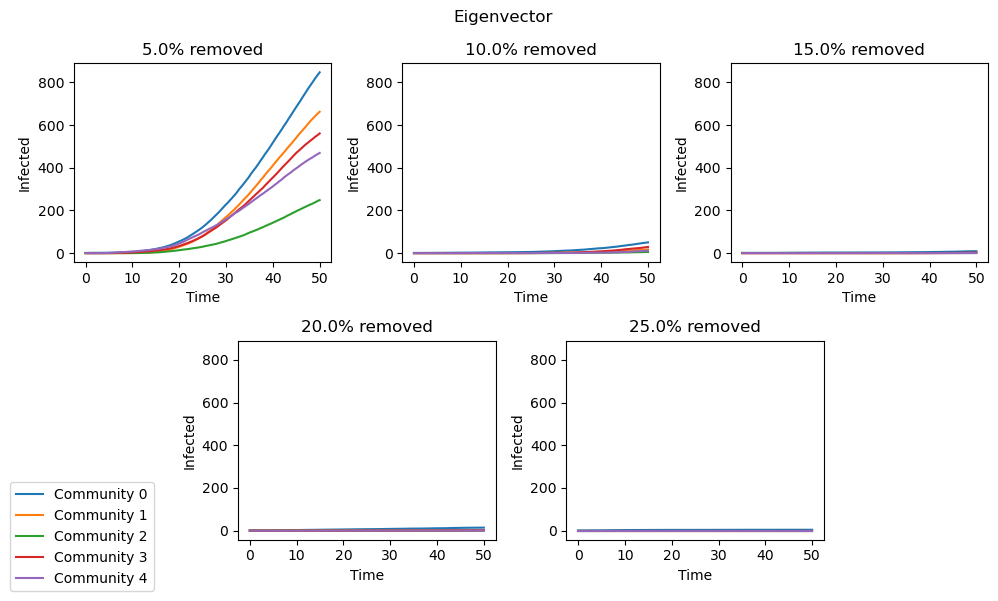

In [19]:
# Plot the results
fig = plt.figure(figsize=(10, 6))
fig.suptitle('Eigenvector')
gs = fig.add_gridspec(2, 6)

ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:4], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 4:], sharey=ax1)
ax4 = fig.add_subplot(gs[1, 1:3], sharey=ax1)
ax5 = fig.add_subplot(gs[1, 3:5], sharey=ax1)

axs = [ax1, ax2, ax3, ax4, ax5]

for ax, remove_percent in zip(axs, remove_percents):
    for community in top_community_nodes:
        ax.plot(np.linspace(0, TMAX, 100), remove_percent_infected[remove_percent][community], label=f"Community {community}")
    ax.set_title(f"{remove_percent * 100}% removed")
    ax.set_xlabel('Time')
    ax.set_ylabel('Infected')

# Common legend
legend = fig.legend(*ax.get_legend_handles_labels(), loc='lower left', bbox_to_anchor=(0, 0))

plt.tight_layout()
plt.show()